# Topological fingerprinting

This notebook gives an example of how to use the topological fingerprinting method.

The tracks used in this example are available here: [Track 1](https://pixabay.com/music/beats-jazzy-abstract-beat-11254/), [Track 2](https://pixabay.com/music/future-bass-powerful-beat-121791/).


In [2]:
import re 
import numpy as np
from itertools import product
import matplotlib.pyplot as plt

from audioId.core import audio, spectrogram
from audioId.pipeline import window_to_ph_vector
from audioId.pipeline import fingerprint_audio, compare_audios, get_matrix_from_dict, get_windows_from_audio
from audioId.pipeline.match import get_delta_t_matching, get_error_from_matching

from audioId.ph import filtrations, ph
from audioId.ph.vectorization import BettiCurveExact
from audioId.transformations.transformation import MyTransformer, NoiseTransformer

## Load a song and extract a clip

In [3]:
AUDIO_DIR = "./../data"; track_name = "jazzy-abstract-beat-11254.mp3"
track1 = audio.Audio.from_file(f"{AUDIO_DIR}/{track_name}")
#song1.display() #not displaying in order not to share the track!

In [4]:
clip1 = track1.extract(10., 40.)
#clip1.display()

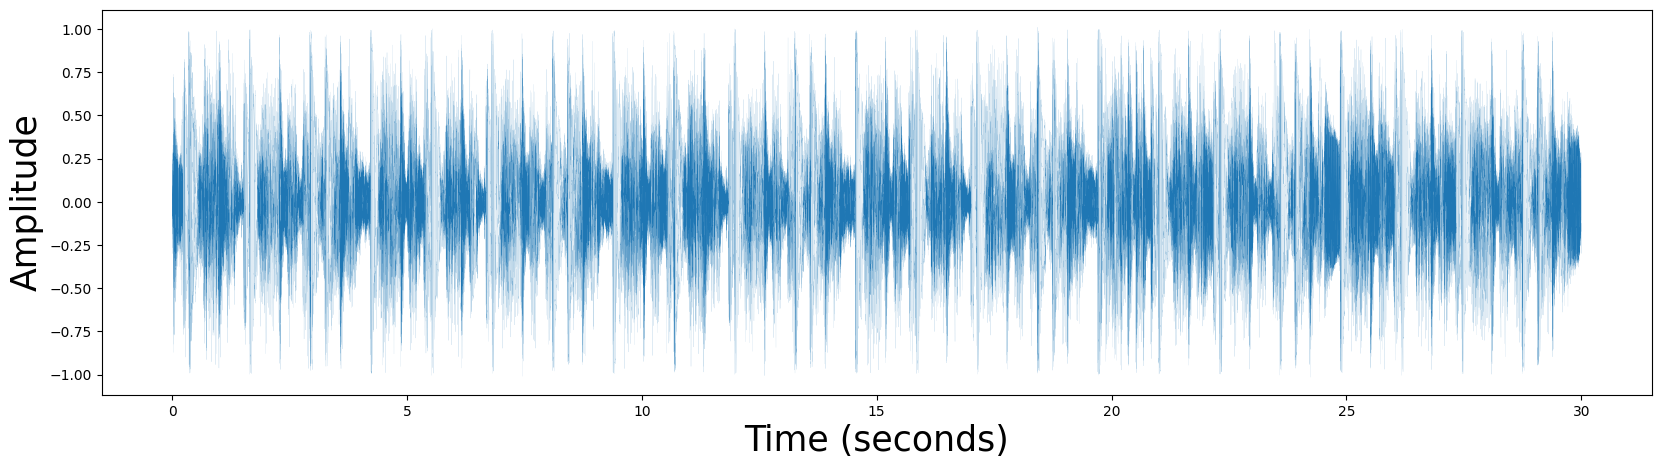

In [5]:
t0, t1 = 0., 30.; arr = clip1.values
fig = plt.figure(figsize = (20,5))
plt.plot(np.linspace(t0, t1, arr.shape[0]), arr, linewidth = 0.05)
_ = plt.xlabel('Time (seconds)', fontsize = 25)
_ = plt.ylabel('Amplitude', fontsize = 25)

### Compute a spectrogram
We illustrate the difference between a standard, Short-Time Fourier Transform spectrogram, and the MelSpectrogram.

/home/wreise/snap/miniconda3/envs/audioId2/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  return f(*args, **kwargs)


[<Axes: title={'center': 'log-frequency spectrogram'}, xlabel='Time (s)', ylabel='Hz'>]

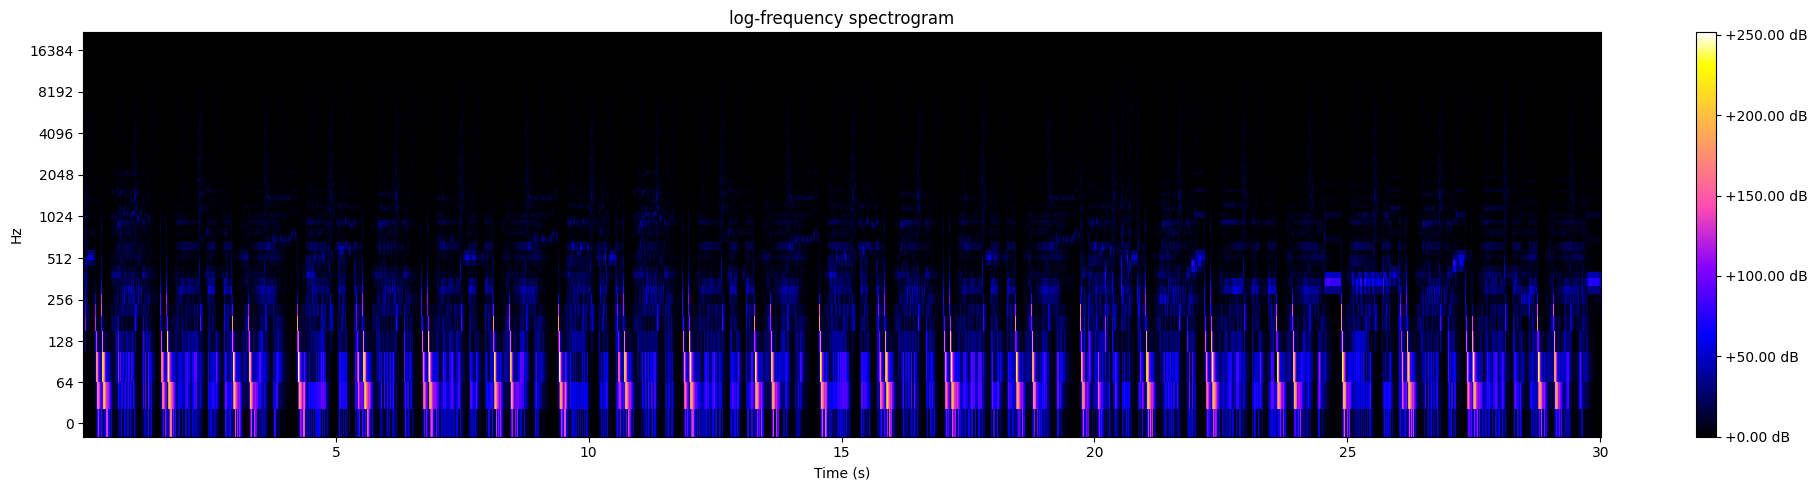

In [6]:
spec_stft = spectrogram.STFT.from_audio(clip1)
spec_stft.display()

[<Axes: title={'center': 'mel-frequency spectrogram'}, xlabel='Time (s)', ylabel='Hz'>]

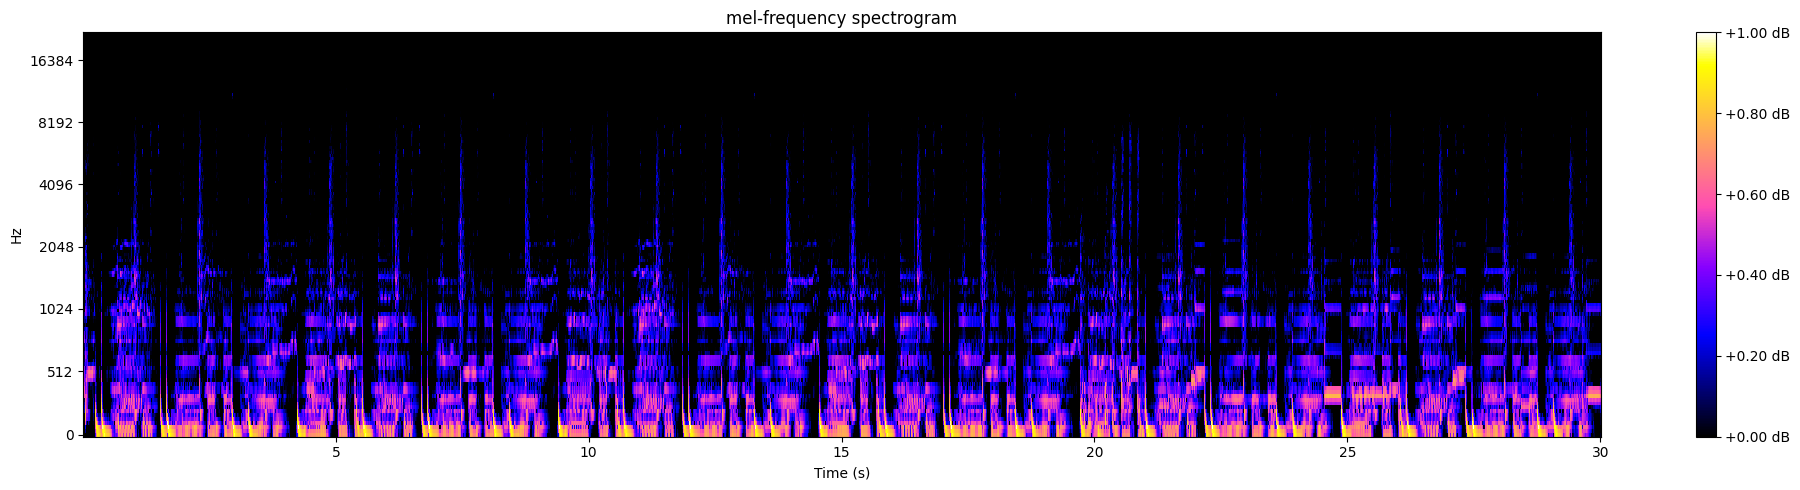

In [7]:
spectrogram.MelSpectrogram.from_audio(clip1).amplitude_to_db().normalize().display()

In [27]:
spec_stft.spec.shape

(513, 5168)

## Fingerprinting and comparing tracks
We first compute the fingerprint of a single window. Then, we use the `audioId.pipeline.fingerprint_audio` method to compute fingerprints.


In [8]:
fingerprint_params = dict(
    spectrogramFct=spectrogram.MelSpectrogram,
    filter_fct=filtrations.intensity,
    compute_ph=ph.compute_ph_super_level,
    vect={0: BettiCurveExact(True), 1: BettiCurveExact(True)}
)
lambda_value = 0.3; weights = np.array([lambda_value, 1.-lambda_value])

In [9]:
#fingerprint = fingerprint_audio(audio, **fingerprint_params)

In [10]:
windows1 = get_windows_from_audio(clip1, spectrogram.MelSpectrogram)
key = (2.4,3.4)

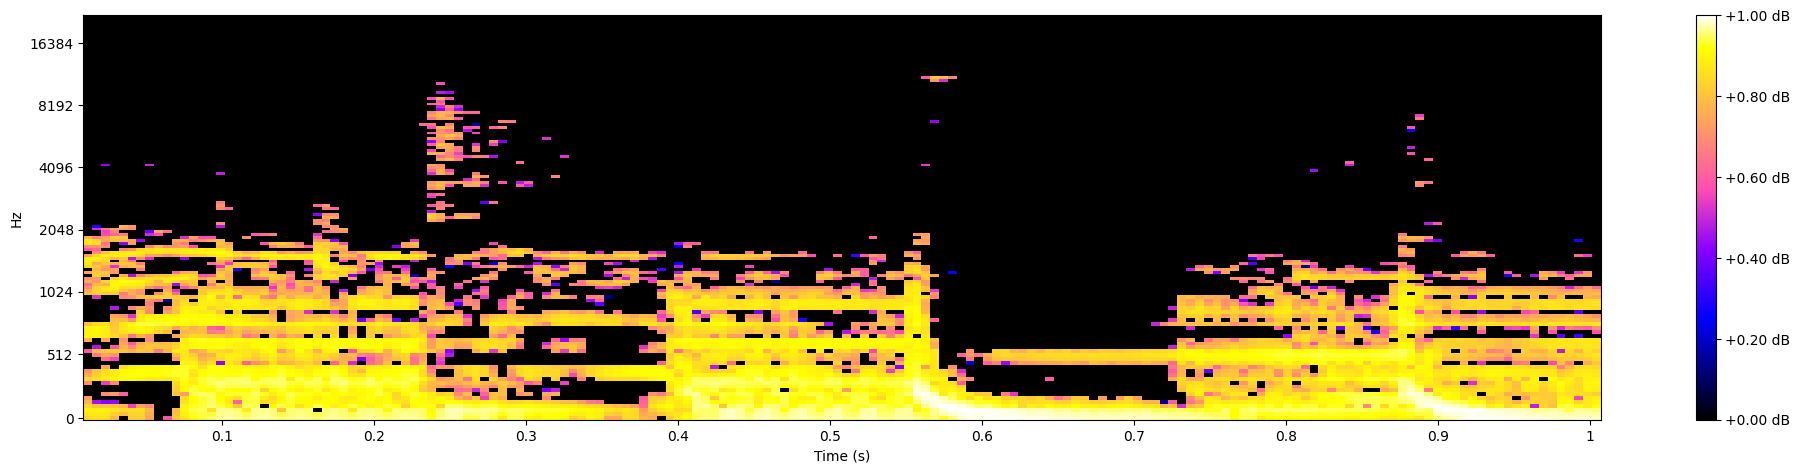

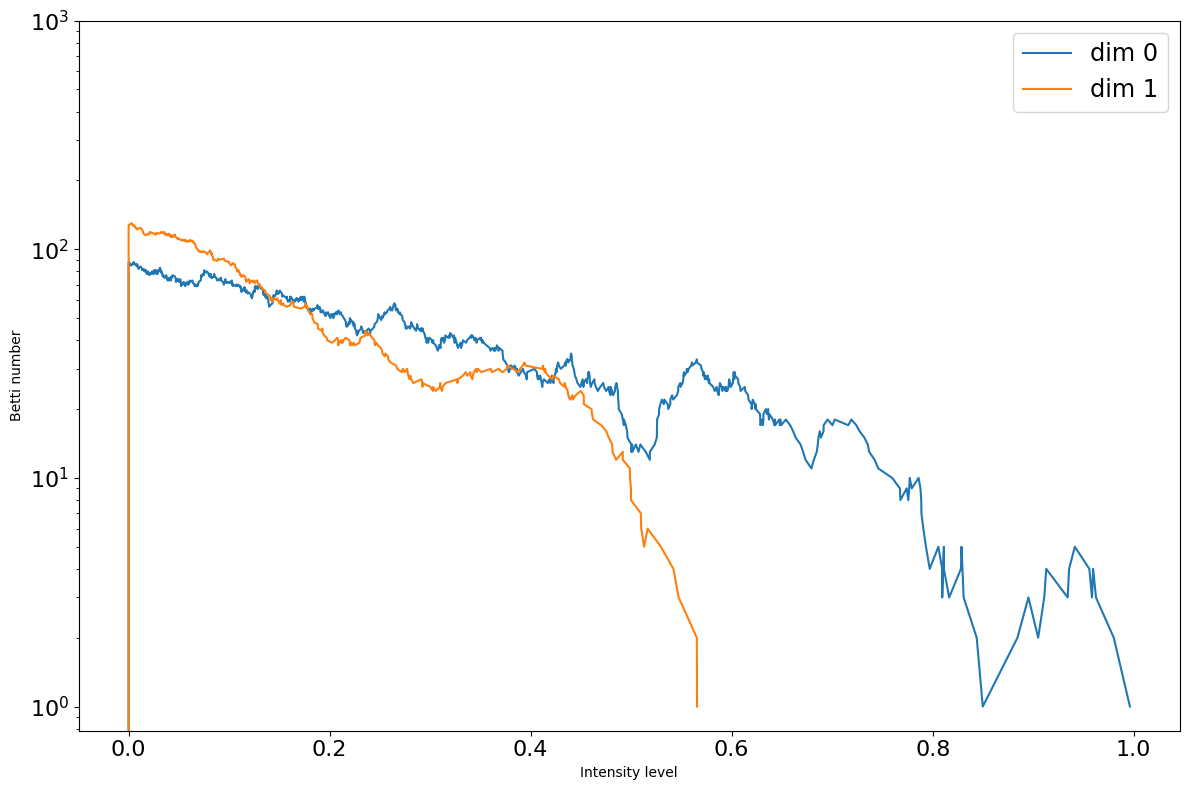

In [11]:
windows1[key].amplitude_to_db().normalize().display()
plt.title('')
bc = window_to_ph_vector(windows1[key], compute_ph=fingerprint_params["compute_ph"],
                         filter_fct=fingerprint_params["filter_fct"],
                         vect=fingerprint_params["vect"])

fig, ax = plt.subplots(1, 1, figsize=(12,8),)
for dim, s in zip(range(2), ['-', '-']):
    ax.semilogy(bc[dim][0], bc[dim][1], s, label = 'dim {0}'.format(dim))
ax.set_ylim(top=1000)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylabel('Betti number')
plt.xlabel('Intensity level')
plt.legend(fontsize='xx-large')
plt.tight_layout()

### Load a second track and compare the two

In [12]:
track_name_2 = "powerful-beat-121791.mp3"
track2 = audio.Audio.from_file(f"{AUDIO_DIR}/{track_name_2}")
clip2 = track2.extract(5., 35.)
#clip2.display()

In [13]:
windows2 = get_windows_from_audio(clip2, spectrogram.MelSpectrogram)
key = (2.4,3.4)

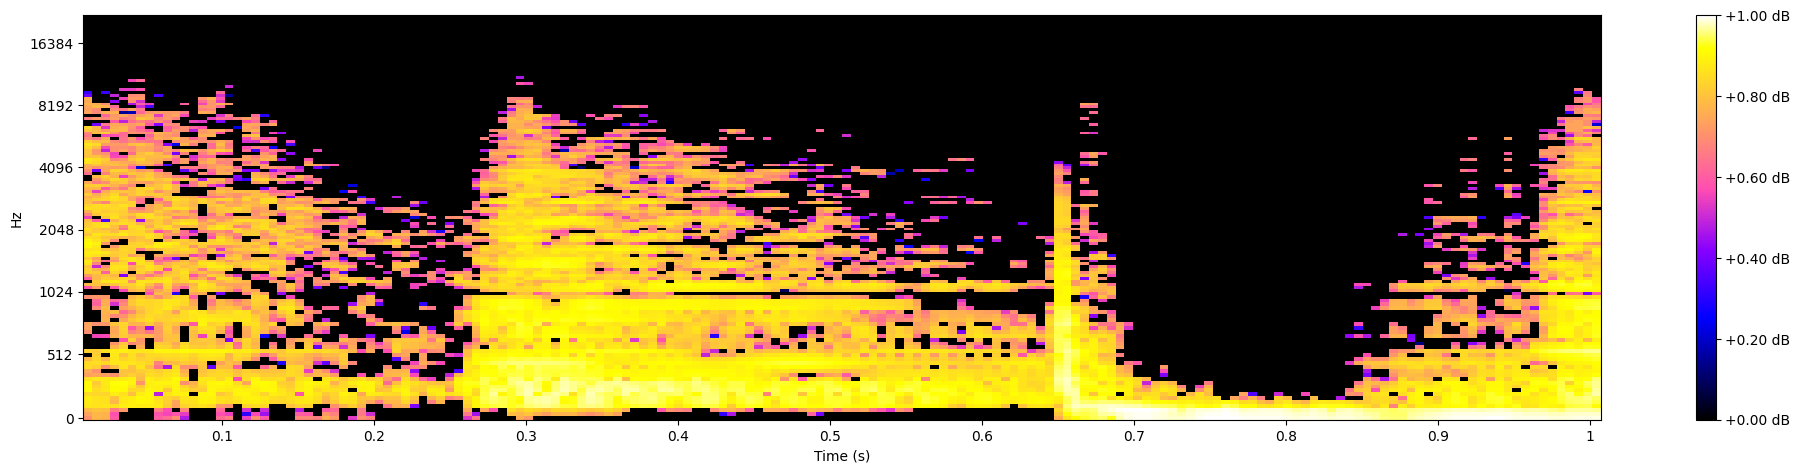

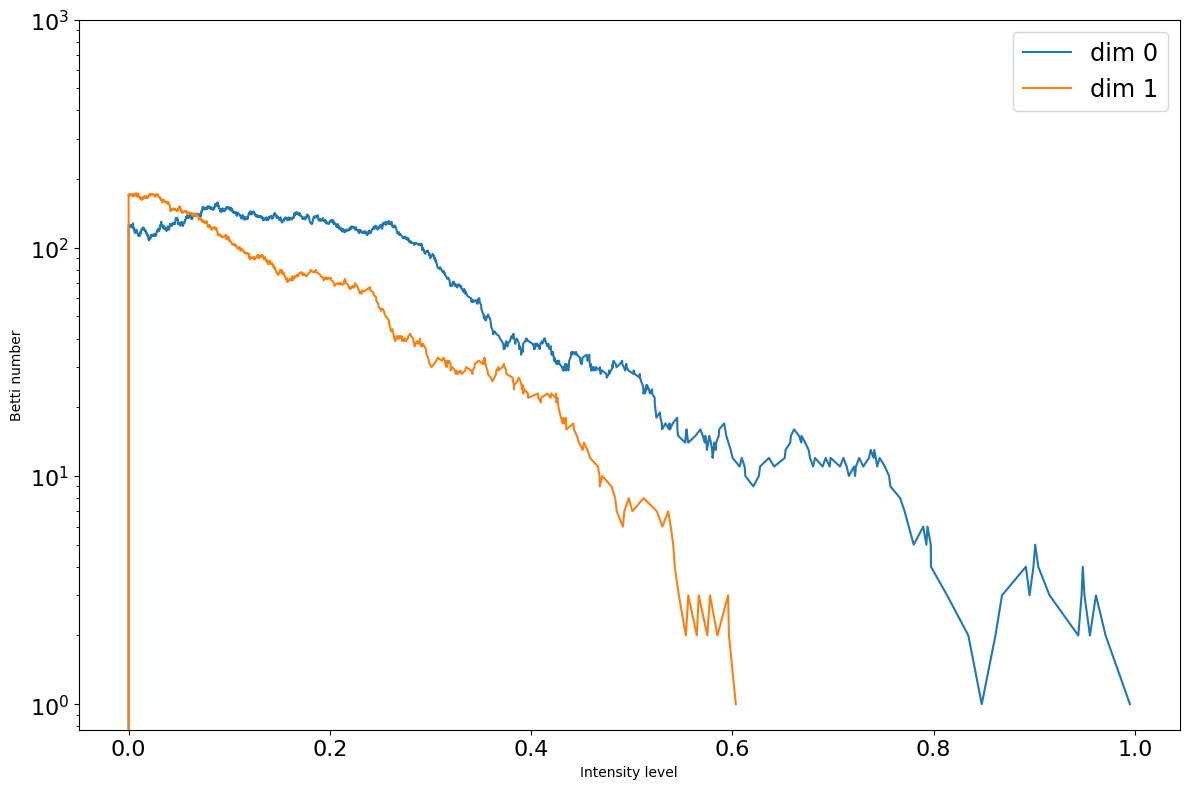

In [14]:
windows2[key].amplitude_to_db().normalize().display()
plt.title('')
bc = window_to_ph_vector(windows2[key], compute_ph=fingerprint_params["compute_ph"],
                         filter_fct=fingerprint_params["filter_fct"],
                         vect=fingerprint_params["vect"])

fig, ax = plt.subplots(1, 1, figsize=(12,8),)
for dim, s in zip(range(2), ['-', '-']):
    ax.semilogy(bc[dim][0], bc[dim][1], s, label = 'dim {0}'.format(dim))
ax.set_ylim(top=1000)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylabel('Betti number')
plt.xlabel('Intensity level')
plt.legend(fontsize='xx-large')
plt.tight_layout()

### Compare the fingerprints of the two clips

In [15]:
comparison_12 = compare_audios(clip1, clip2, **fingerprint_params)

In [16]:
distances, keys_1, keys_2 = get_matrix_from_dict(comparison_12, windows1, windows2)
d = {'distances': distances, 'keys_1': keys_1, 'keys_2': keys_2}

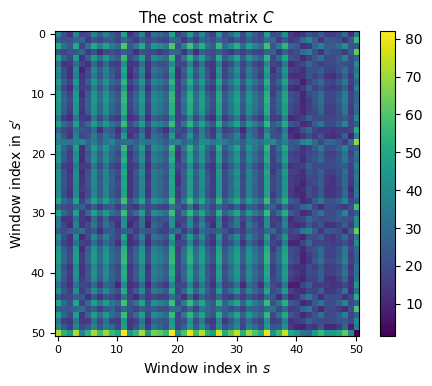

In [17]:
dist = np.array(d["distances"])
cost = np.dot(dist, weights)

plt.figure(figsize=(5,4))
plt.imshow(cost)
plt.title('The cost matrix $C$', fontsize = 11)
plt.xlabel('''Window index in $s$''', fontsize = 10)
plt.ylabel('''Window index in $s'$''', fontsize = 10)
_ = plt.colorbar()
plt.tight_layout()
_ = plt.xticks(fontsize = 8)
_ = plt.yticks(fontsize = 8)

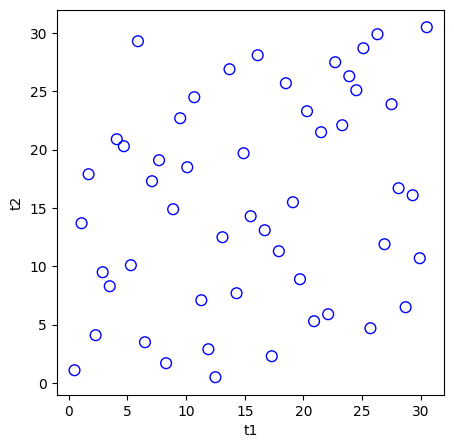

In [18]:
matching_delta_t = get_delta_t_matching(d)
plt.figure(figsize=(5,5))
plt.scatter(matching_delta_t[0], matching_delta_t[1] , s=60, marker='o', edgecolors='b', facecolors='none')
_ = plt.ylabel("t2")
_ = plt.xlabel("t1")

In [19]:
get_error_from_matching(matching_delta_t)

0.44457413702419

## Obfuscate one of the clips
We obfuscate the first clip, creating a 'positive pair' and we repeat the fingerprinting and comparison process.

In [20]:
clip1.to_file("./../data/clip1.ogg")

/home/wreise/Projects/AUDIO_ID/new_git_repo/audioId/core/audio.py:49: UserWarning: Test!
  warnings.warn("Test!")


True

In [21]:
available_obfuscation_types = ['lowpass', 'highpass', 'pitch', 'tempo', 'whitenoise', 'pinknoise', 'reverb']
def get_transformer(obfuscation_type, degree):
    if obfuscation_type in ['whitenoise', 'pinknoise']:
        return NoiseTransformer(degree=degree, noise_type=obfuscation_type)
    else:
        m = MyTransformer()
        fct = getattr(m, obfuscation_type)
        return fct(degree)

obfuscation_name = "pitch"; degree = 1.3
#obfuscation_name = "whitenoise"; degree = 0.3
#obfuscation_name = "highpass"; degree = 100
transformer = get_transformer(obfuscation_name, degree)
transformer.apply("clip1", AUDIO_DIR+"/", f"clip1_{obfuscation_name}", AUDIO_DIR+"/")
clip1_obfuscated = audio.Audio.from_file(f"{AUDIO_DIR}/clip1_{obfuscation_name}.ogg")

ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-li

In [22]:
comparison_12 = compare_audios(clip1, clip1_obfuscated, **fingerprint_params)

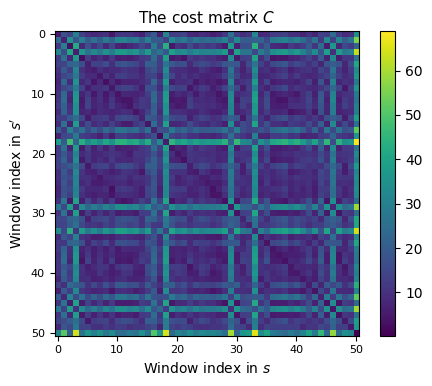

In [23]:
distances, keys_1, keys_2 = get_matrix_from_dict(comparison_12, windows1, windows2)
d = {'distances': distances, 'keys_1': keys_1, 'keys_2': keys_2}
dist = np.array(d["distances"])
cost = np.dot(dist, weights)

plt.figure(figsize=(5,4))
plt.imshow(cost)
plt.title('The cost matrix $C$', fontsize = 11)
plt.xlabel('''Window index in $s$''', fontsize = 10)
plt.ylabel('''Window index in $s'$''', fontsize = 10)
_ = plt.colorbar()
plt.tight_layout()
_ = plt.xticks(fontsize = 8)
_ = plt.yticks(fontsize = 8)

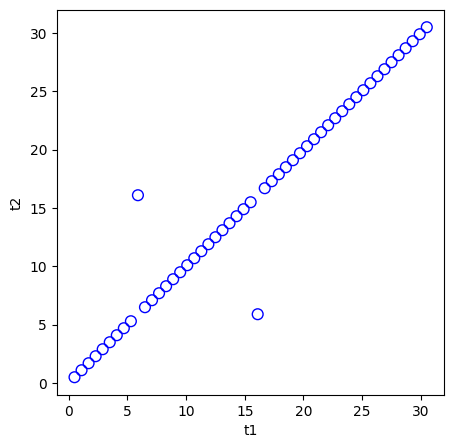

In [24]:
matching_delta_t = get_delta_t_matching(d)
plt.figure(figsize=(5,5))
plt.scatter(matching_delta_t[0], matching_delta_t[1] , s=60, marker='o', edgecolors='b', facecolors='none')
_ = plt.ylabel("t2")
_ = plt.xlabel("t1")

In [25]:
get_error_from_matching(matching_delta_t)

0.00026525230876839334